# Random Forest (Ensemble Model)

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Plotting graphs
import matplotlib.pyplot as plt

# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from pprint import pprint
import xgboost as xgb #conda install -c conda-forge xgboost
from bayes_opt import BayesianOptimization #pip install bayesian-optimization

from ta import add_all_ta_features #pip install --upgrade ta https://github.com/bukosabino/ta https://medium.datadriveninvestor.com/predicting-the-stock-market-with-python-bba3cf4c56ef
from fastai.tabular.all import add_datepart #pip install fastai https://docs.fast.ai/tabular.core.html https://www.analyticsvidhya.com/blog/2018/10/predicting-stock-price-machine-learningnd-deep-learning-techniques-python/

### (Part0) Data Preparation & Helper Function

We will use Apple Stock Price data from 2021-12-29 to 2021-4-28 (4month). We will include all the technical features we produced to perform feature selection. 

In [2]:
def prepare_dataset(path = 'data/AAPL_data.csv', select_feature = True, start_date = '2021-12-29'):
    '''
    Load dataset and generate technical features and limit time periods. 

    path(str) : path to the data file.
    select_feature(boolean) : if true keep selected features
    start_date(str) : start date of interested time period. 
    '''
    df = pd.read_csv(path)
    df.dropna()

    df["Date"]=pd.to_datetime(df.Date, format="%Y-%m-%d")
    df.index=df['Date']
    data = df.sort_index(ascending=True, axis=0)
    add_datepart(df, 'Date', drop=False)
    df.drop('Elapsed', axis=1, inplace=True)

    df = add_all_ta_features(
        df, high="High", low="Low", open="Open", close="Close", volume="Volume")
    
    df = df[df['Date'] >= start_date]

    X = df.drop(['Close', 'trend_psar_down', 'trend_psar_up', 'Date', 'Adj Close'], axis=1)
    y = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)

    if select_feature:
        selected_features = ['trend_sma_fast', 'trend_ema_fast', 'momentum_stoch_rsi_k', 'momentum_stoch_rsi_d', 'momentum_rsi', \
                    'trend_macd', 'momentum_wr', 'volume_adi', 'momentum_roc', 'volume_obv', \
                    'volatility_bbh', 'volatility_bbl']
        basic_features = ['High', 'Low', 'Open', 'Volume', 'Year', 'Month', 'Week', 'Day', 'Dayofweek']
        X = X[selected_features + basic_features]

    return X, y

In [3]:
# Data with full set of technical features
X_pandas, y = prepare_dataset(select_feature=False)
X = np.array(X_pandas)

c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
c:\Users\Maggie Chen\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


**Train/Test Data Split and Data Normalization**

In [4]:
# Convert data to float32 for PyTorch
X = X.astype(np.float32)

# Split training and validation data
split = int(0.8 * len(X))
X_train = X[:split]
X_valid = X[split:]

y_train = y[:split]
y_valid = y[split:]

#scale data
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)

**Helper Function for Feature Importance Evaluation**

In [5]:
#to find feature importances of an already built-up RF model
#can refer to the sklearn materials here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
def feature_importance(model): 
    importances = model.feature_importances_
    feature_names = [i for i in X_pandas.columns]
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=False)
    
    print('Top 20 Best Features : \n')
    print(forest_importances.head(20))
    fig, ax = plt.subplots(figsize=(30,20))
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

### (Part1) Random Forest

In this part, we will implement random forest classifier model. 

**Baseline Model Without Hyperparameter Tuning**

In [6]:
base_model = RandomForestClassifier(random_state=42)
base_model.fit(X_train, y_train)
base_predict = base_model.predict(X_valid)

In [7]:
print(metrics.classification_report(y_valid, base_predict))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17



c:\Users\Maggie Chen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [8]:
base_accuracy = base_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(base_accuracy*100))

Accuracy = 64.71%.


Top 20 Best Features : 

trend_kst_sig              0.052320
volume_vwap                0.040093
trend_mass_index           0.025000
trend_ichimoku_a           0.024063
trend_sma_slow             0.023060
momentum_pvo_signal        0.020955
trend_ichimoku_base        0.019899
volatility_kcc             0.019861
Open                       0.019667
Low                        0.019458
others_cr                  0.018640
High                       0.017944
Day                        0.017766
trend_adx                  0.017494
trend_visual_ichimoku_a    0.016789
momentum_pvo               0.016023
volatility_kcw             0.015555
trend_stc                  0.014399
volatility_bbm             0.014261
volatility_atr             0.014175
dtype: float64


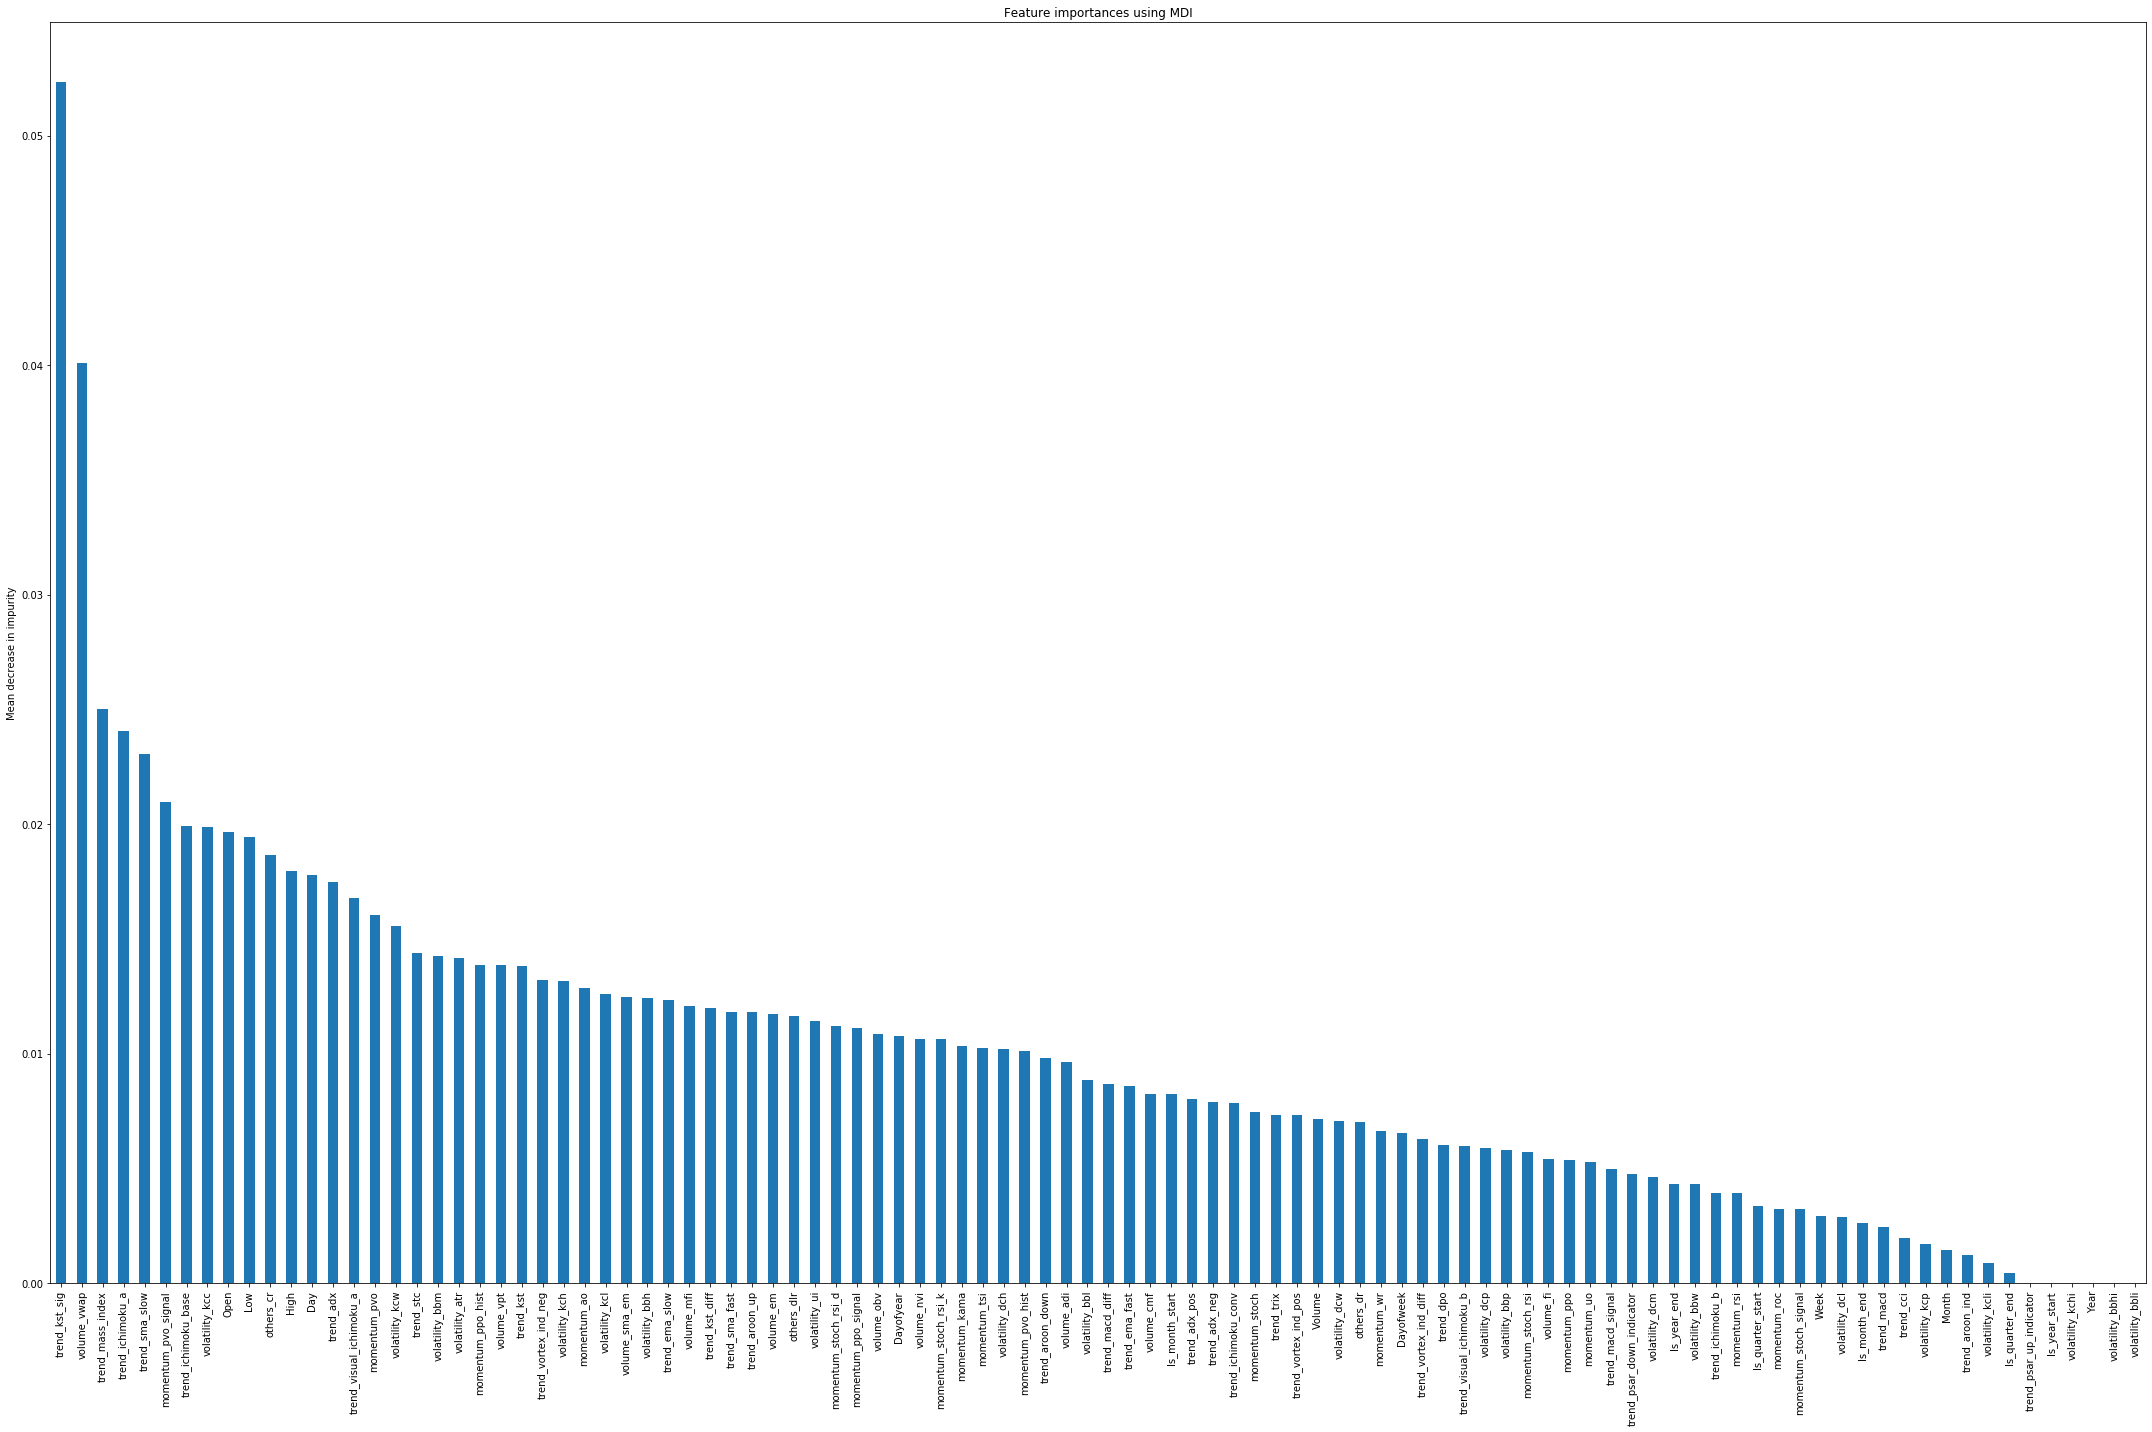

In [9]:
feature_importance(base_model) #calling the helper function
#do we have macd (moving average convergence divergence here)
#can we give an explanation of these indicators

**Hyperparameter tuning by random search**  

[Reference](https://medium.com/@maryamuzakariya/project-predict-stock-prices-using-random-forest-regression-model-in-python-fbe4edf01664#:~:text=The%20random%20forest%20regression%20model,based%20on%20the%20predicted%20values)

In [10]:
def test_params(**params):
    model = RandomForestClassifier(random_state=42, n_jobs=-1, **params).fit(X_train, y_train)
    return model.score(X_train, y_train), model.score(X_valid, y_valid)

In [11]:
def test_param_and_plot(param_name, param_values):
    train_accs, test_accs = [], []
    for value in param_values:
        params = {param_name:value}
        train_acc, test_acc = test_params(**params)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_accs, 'b-o')
    plt.plot(param_values, test_accs, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('Accuracy')
    plt.legend(['Training', 'Testing'])

In [12]:
rf = RandomForestClassifier()
# Look at parameters used by current forest, and the param need to be tuned to find the best 
# for our current dataset
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)

In [15]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [16]:
best = rf_random.best_params_
print('Parameters currently in use:\n')
print(best)

Parameters currently in use:

{'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 50, 'bootstrap': True}


**Model after Hyperparameter Tuning**

In [17]:
hyper_model = RandomForestClassifier(n_estimators=best["n_estimators"], min_samples_split=best["min_samples_split"], \
        min_samples_leaf=best["min_samples_leaf"], max_features=best["max_features"], max_depth=best["max_depth"], \
        bootstrap=best["bootstrap"], random_state=42)

In [18]:
hyper_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=50, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [19]:
hyper_predict = hyper_model.predict(X_valid)

In [20]:
print(metrics.classification_report(y_valid, hyper_predict))

              precision    recall  f1-score   support

           0       0.60      0.82      0.69        11
           1       0.00      0.00      0.00         6

    accuracy                           0.53        17
   macro avg       0.30      0.41      0.35        17
weighted avg       0.39      0.53      0.45        17



In [21]:
hyper_accuracy = hyper_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(hyper_accuracy*100))
print('Improvement of {:0.2f}%.'.format( 100 * (hyper_accuracy - base_accuracy) / base_accuracy))

Accuracy = 52.94%.
Improvement of -18.18%.


Top 20 Best Features : 

trend_stc                0.054751
volume_vwap              0.050751
Low                      0.047479
trend_vortex_ind_neg     0.046665
trend_kst_sig            0.045548
volume_mfi               0.042844
trend_ichimoku_base      0.038566
volatility_dch           0.035577
volatility_atr           0.032342
momentum_stoch_rsi_k     0.028618
trend_kst_diff           0.028612
trend_vortex_ind_diff    0.027489
volatility_bbm           0.027015
others_cr                0.025374
trend_adx_neg            0.024921
momentum_ao              0.023412
volatility_kch           0.023366
others_dlr               0.022939
Open                     0.021442
volatility_dcl           0.020671
dtype: float64


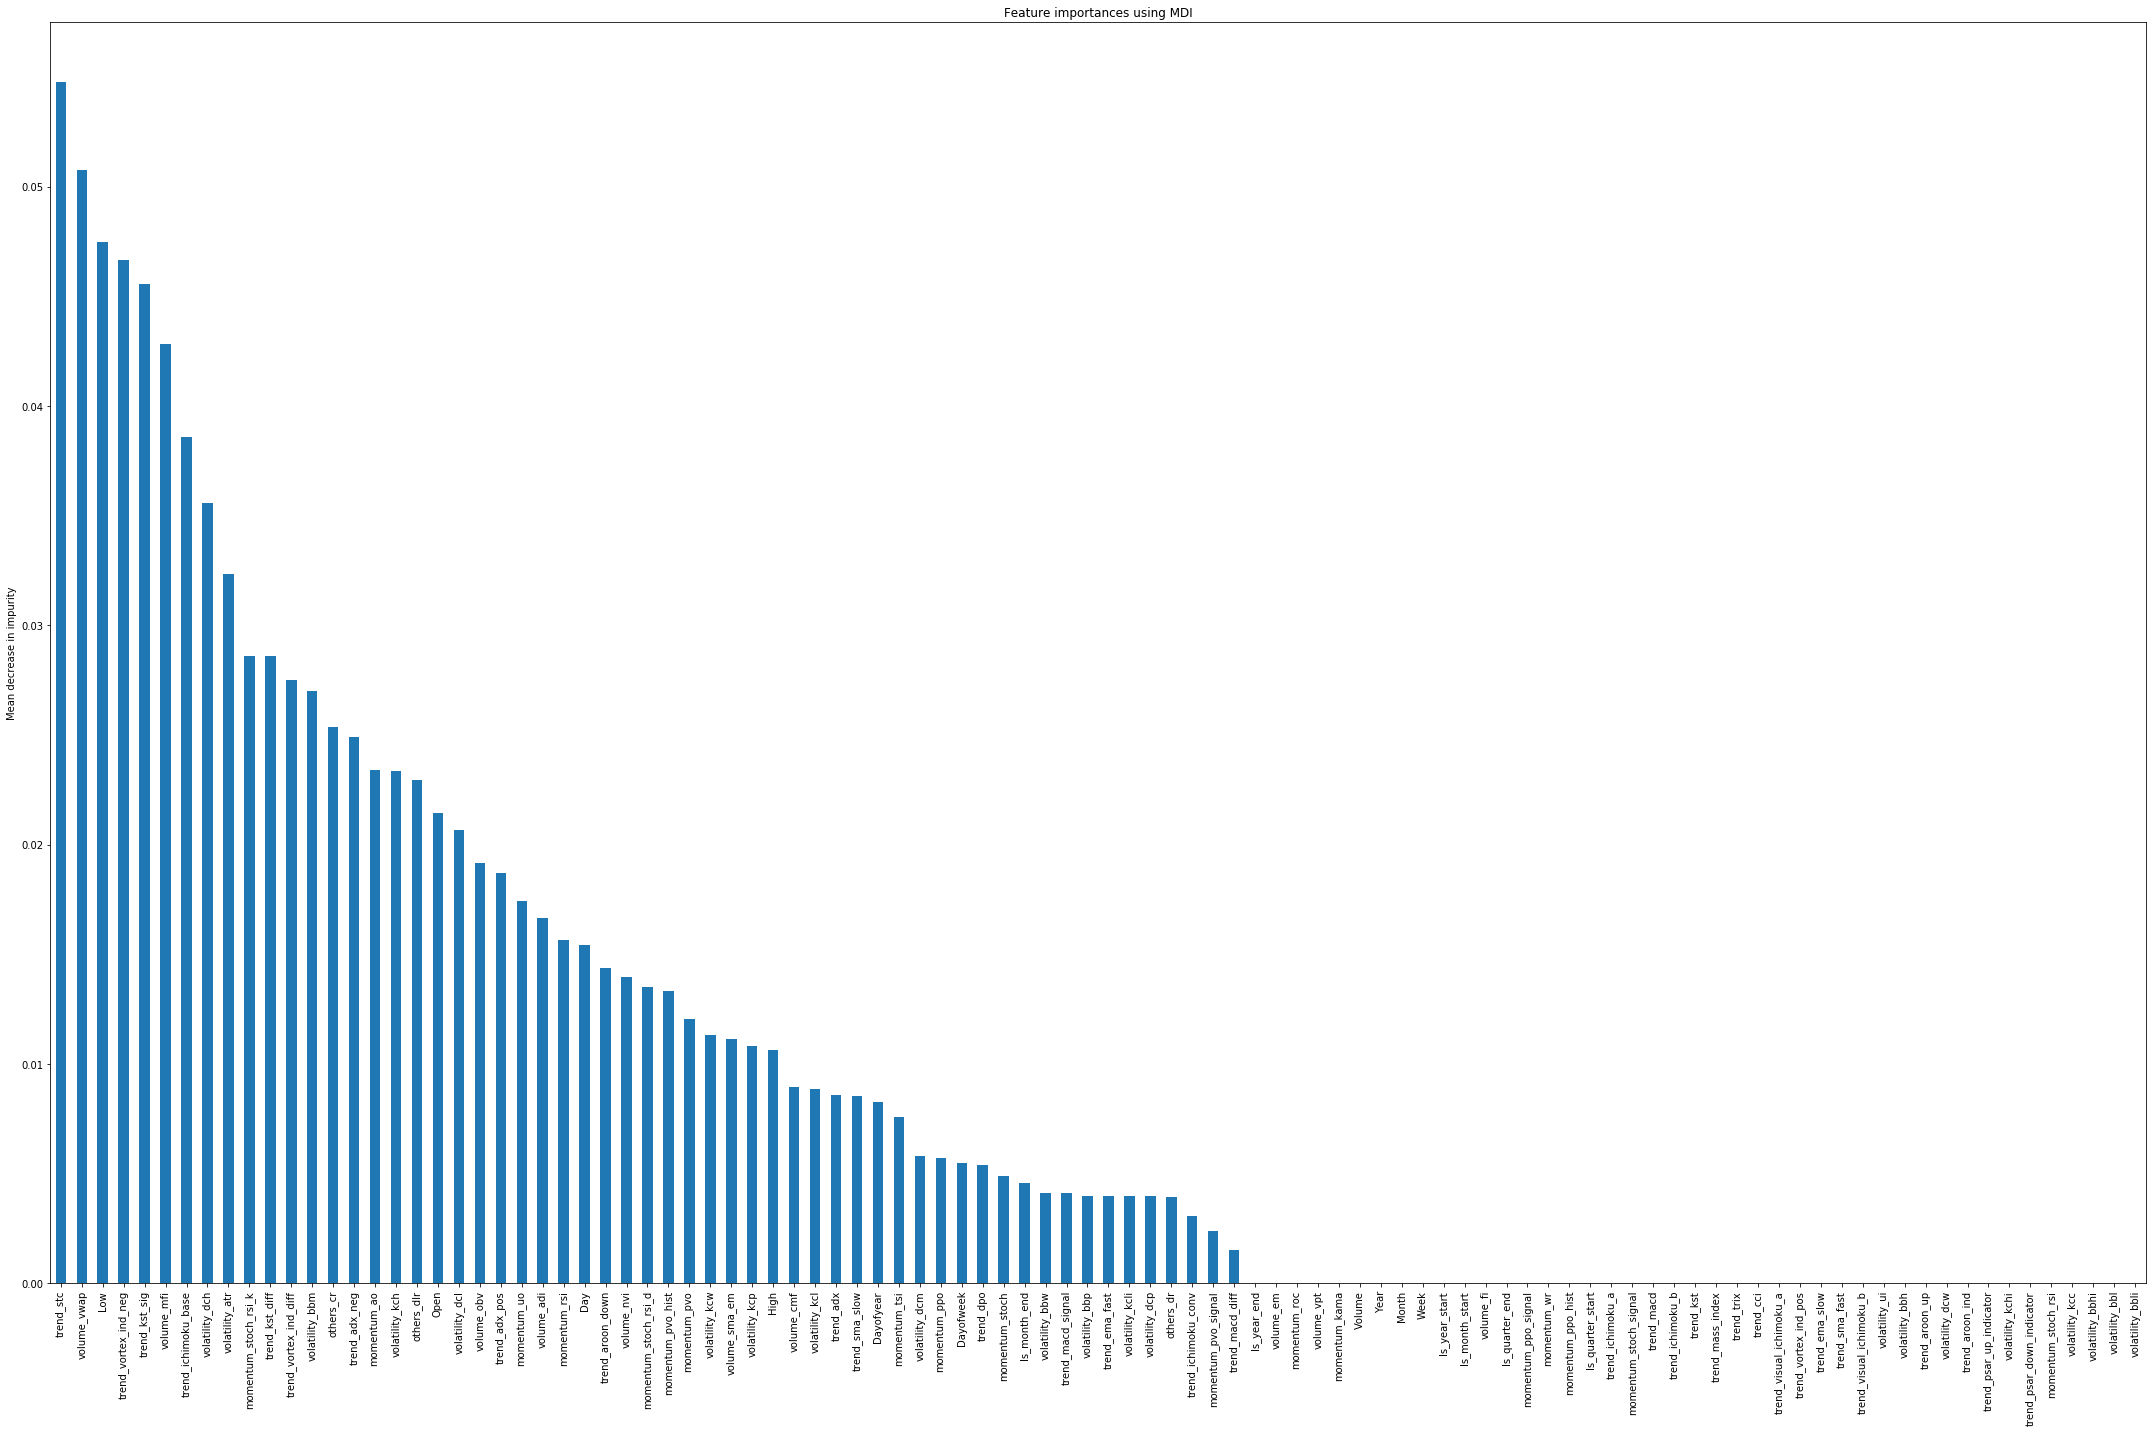

In [22]:
feature_importance(hyper_model)

### Part(2) Adaboost

In this part, we will implement Adaboost model. (as another ensemble model)

In [23]:
ada_model = AdaBoostClassifier(random_state=42)
ada_model.fit(X_train, y_train)
ada_predict = ada_model.predict(X_valid)
print(metrics.classification_report(y_valid, ada_predict))

              precision    recall  f1-score   support

           0       0.73      0.73      0.73        11
           1       0.50      0.50      0.50         6

    accuracy                           0.65        17
   macro avg       0.61      0.61      0.61        17
weighted avg       0.65      0.65      0.65        17



In [24]:
ada_accuracy = ada_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(ada_accuracy*100))
print('Improvement of {:0.2f}%.'.format( 100 * (ada_accuracy - base_accuracy) / base_accuracy))

Accuracy = 64.71%.
Improvement of 0.00%.


Top 20 Best Features : 

trend_stc                  0.10
momentum_pvo               0.08
trend_kst_sig              0.06
trend_dpo                  0.06
momentum_ppo_hist          0.06
volume_obv                 0.04
momentum_stoch_rsi_k       0.04
momentum_stoch             0.04
trend_mass_index           0.04
volatility_bbl             0.04
volatility_kcp             0.04
trend_kst_diff             0.04
Volume                     0.04
volatility_bbp             0.02
trend_cci                  0.02
trend_visual_ichimoku_a    0.02
trend_vortex_ind_pos       0.02
trend_aroon_down           0.02
volume_adi                 0.02
volatility_bbw             0.02
dtype: float64


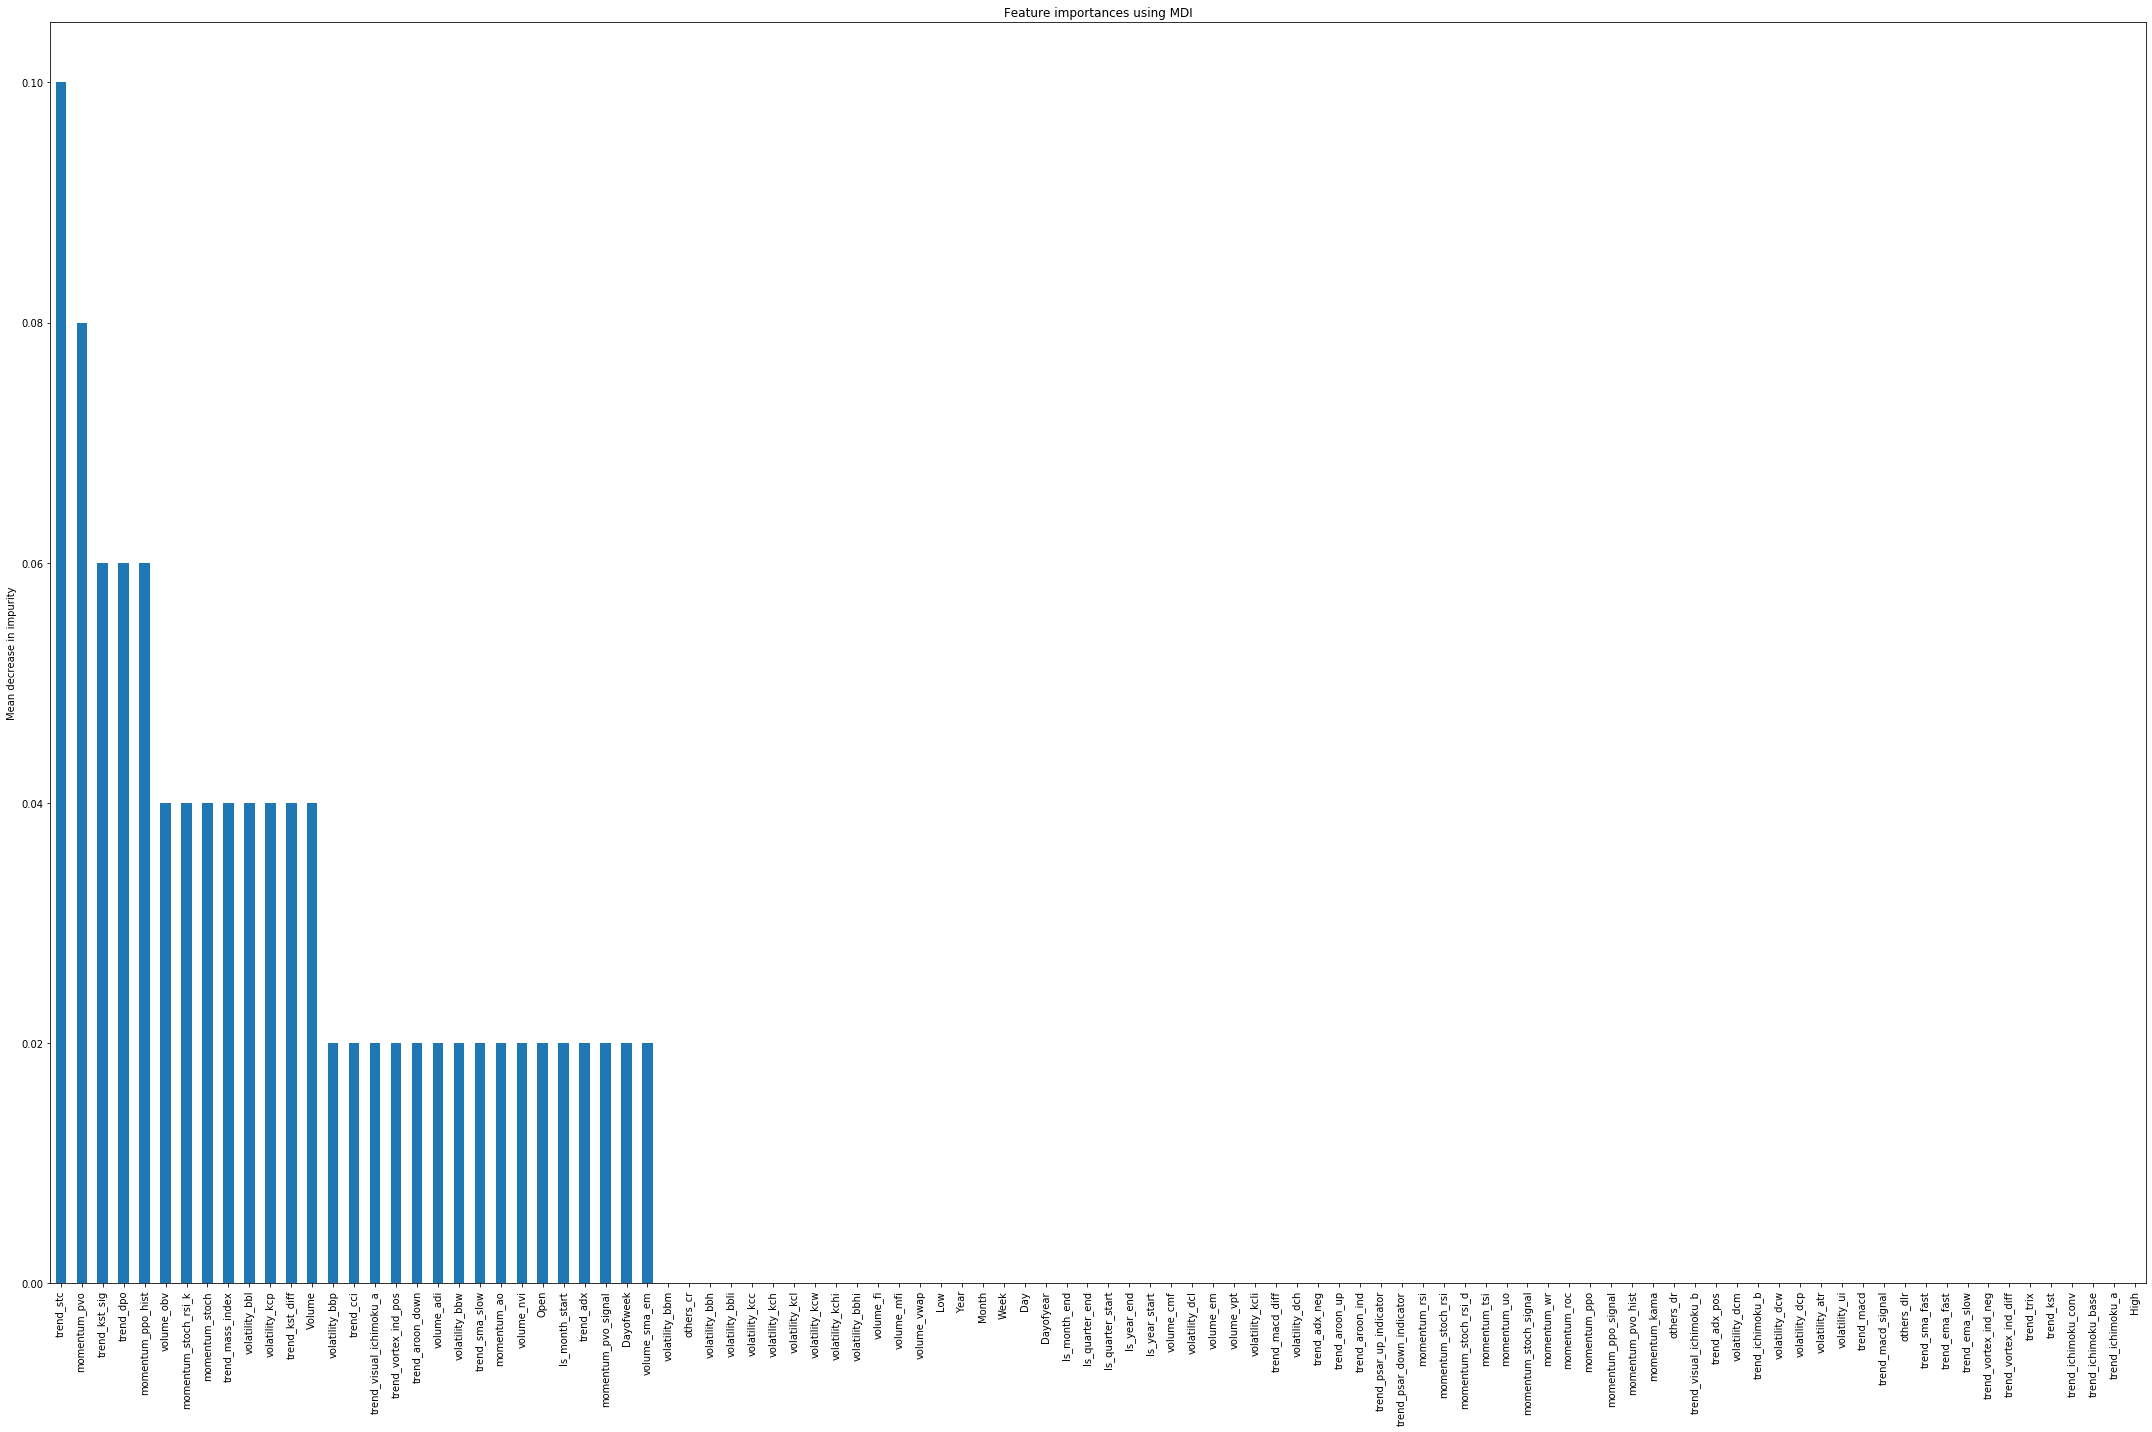

In [25]:
feature_importance(ada_model)

In [26]:
# Hyperparameter tuning : Didn't improve accuracy
random_grid_adaboost = {'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 500, num = 10)], 
               'algorithm': ['SAMME', 'SAMME.R'],
               'learning_rate':[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}
ad = AdaBoostClassifier()
ad_random = RandomizedSearchCV(estimator = ad, param_distributions = random_grid_adaboost, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)
ad_random.fit(X_train, y_train)
ad_best = ad_random.best_params_
print('Parameters currently in use:\n')
print(ad_best)
hyper_ada_model = AdaBoostClassifier(n_estimators=ad_best['n_estimators'], learning_rate=ad_best['learning_rate'], algorithm=ad_best['algorithm'], random_state=42)
hyper_ada_model.fit(X_train, y_train)
hyper_ada_predict = hyper_ada_model.predict(X_valid)
print(metrics.classification_report(y_valid, hyper_ada_predict))

Parameters currently in use:

{'n_estimators': 10, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}
              precision    recall  f1-score   support

           0       0.65      1.00      0.79        11
           1       0.00      0.00      0.00         6

    accuracy                           0.65        17
   macro avg       0.32      0.50      0.39        17
weighted avg       0.42      0.65      0.51        17



c:\Users\Maggie Chen\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Part(3) Gradient Boosting

In this part, we will implement Gradient Boosting model. 

In [27]:
gra_model = GradientBoostingClassifier(random_state=42)
gra_model.fit(X_train, y_train)
gra_predict = gra_model.predict(X_valid)
print(metrics.classification_report(y_valid, gra_predict))

              precision    recall  f1-score   support

           0       0.77      0.91      0.83        11
           1       0.75      0.50      0.60         6

    accuracy                           0.76        17
   macro avg       0.76      0.70      0.72        17
weighted avg       0.76      0.76      0.75        17



In [28]:
gra_accuracy = gra_model.score(X_valid, y_valid)
print('Accuracy = {:0.2f}%.'.format(gra_accuracy*100))
print('Improvement of {:0.2f}%.'.format( 100 * (gra_accuracy - base_accuracy) / base_accuracy))

Accuracy = 76.47%.
Improvement of 18.18%.


Top 20 Best Features : 

trend_kst_sig            0.291472
trend_mass_index         0.117730
trend_stc                0.053885
Day                      0.051050
volatility_kcw           0.045950
momentum_ppo_hist        0.040880
momentum_pvo             0.040749
Is_month_start           0.038499
trend_macd_diff          0.027110
volatility_dcp           0.024311
Open                     0.022834
momentum_uo              0.022391
trend_adx                0.019872
volatility_kcp           0.018627
volatility_bbl           0.017418
Dayofweek                0.012898
momentum_stoch_signal    0.012176
volume_nvi               0.011604
momentum_stoch_rsi_k     0.011320
trend_dpo                0.009398
dtype: float64


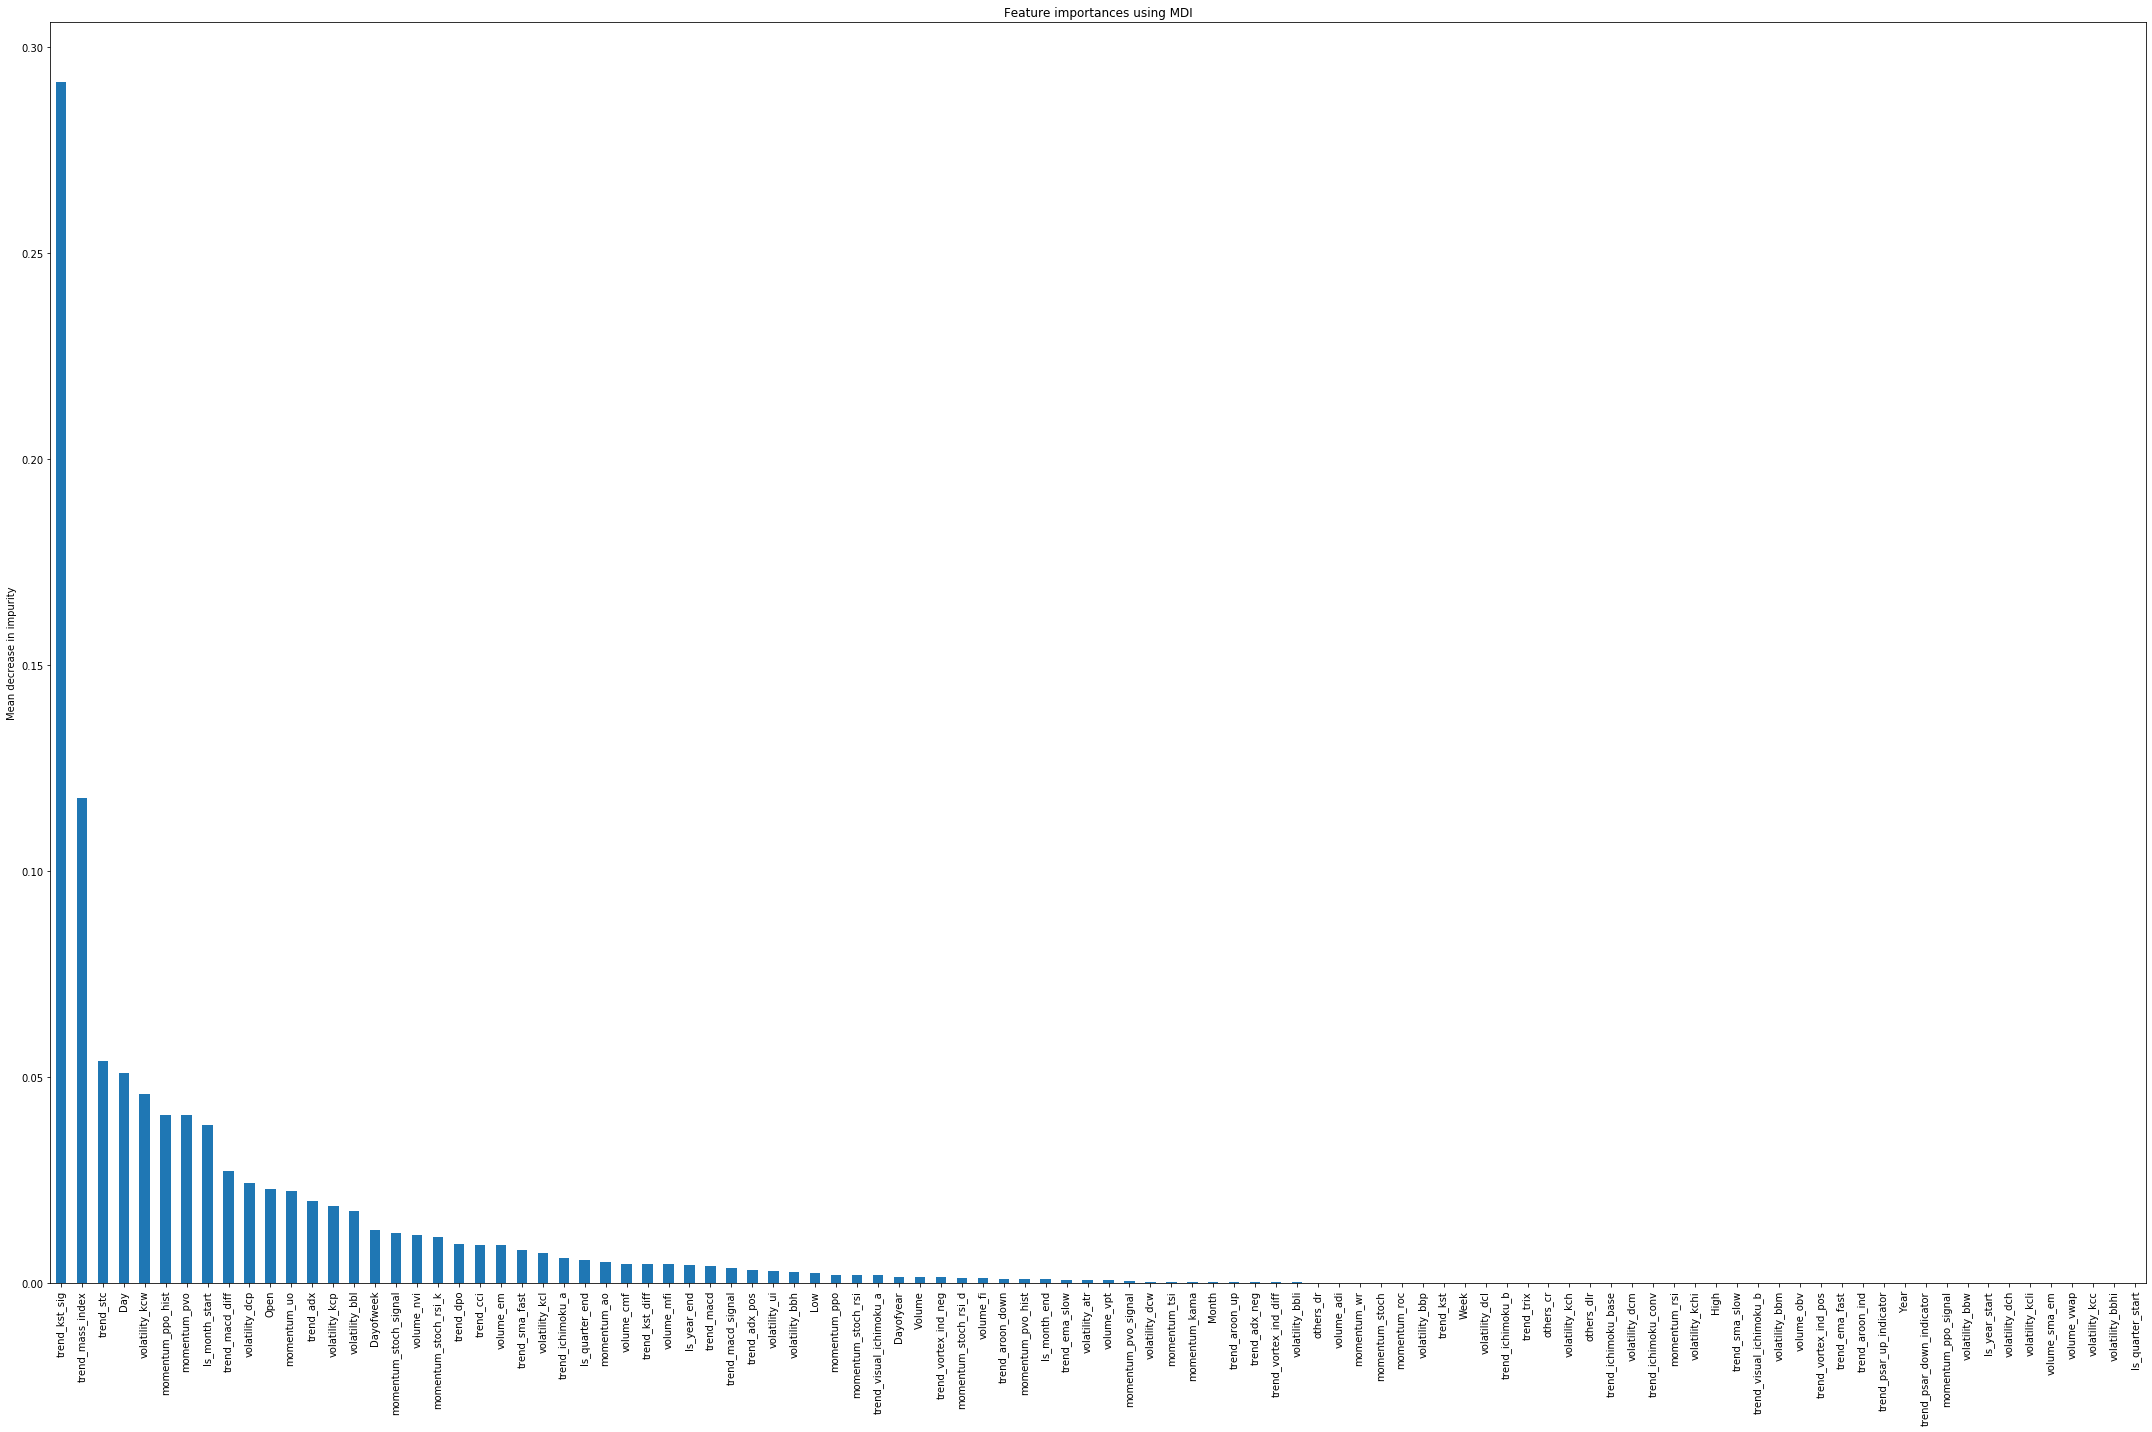

In [29]:
feature_importance(gra_model)

**HP Tuning for Gradient Boosting**  
 - by using xgb_classifier (need to make labels in the range of [0,1])  
 - by using randomized search cv

Approach 1

In [30]:
#optimize n_estimators, max_depth, num_boost_round, etc.
def xgb_classifier(n_estimators, max_depth, reg_alpha,
                   reg_lambda, min_child_weight, num_boost_round,
                   gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    train_data = xgb.DMatrix(X_train, y_train)
    cv_result = xgb.cv(params,
                       train_data,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

In [31]:
xgbBO = BayesianOptimization(xgb_classifier, {  "n_estimators": (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (10, 500),
                                                "gamma": (0, 10)
                                                })

xgbBO.maximize(n_iter=15, init_points=2)

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | num_bo... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.522    |  4.986    |  36.63    |  3.006    |  65.25    |  487.4    |  0.07004  |  0.0817   |
|  2        |  0.5      |  1.841    |  32.36    |  9.107    |  39.72    |  448.8    |  0.0895   |  0.08065  |
|  3        |  0.6931   |  10.0     |  40.0     |  1.0      |  100.0    |  10.0     |  8.459e-1 |  8.459e-1 |
|  4        |  0.6983   |  0.6369   |  5.963    |  2.376    |  97.98    |  17.36    |  0.01569  |  0.07259  |
|  5        |  0.5      |  9.362    |  5.405    |  8.088    |  99.76    |  114.9    |  0.04548  |  0.05412  |
|  6        |  0.6194   |  10.0     |  5.0      |  1.0      |  10.0     |  10.0     |  0.1      |  0.1      |
|  7        |  0.6153   |  0.4154   |  7.647    |  5.595    |  97.15    |  18.88    |  0.0586   |  0.02545  |
|  8      

The purple ones indicate a better optimal is yielded, hence better hp for our model. 

In [32]:
hyper_model = xgb_classifier(max_depth=5.0, n_estimators=100, gamma = 0.0, \
    min_child_weight = 1.0, num_boost_round = 500, reg_alpha = 0.0, reg_lambda = 0.1)

In [33]:
hyper_model

0.7217950000000001

Approach 2

In [34]:
random_grid_gradient = {'n_estimators': n_estimators,
               'max_features': max_features + ['auto'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}

gr = GradientBoostingClassifier()
gr_random = RandomizedSearchCV(estimator = gr, param_distributions = random_grid_gradient, n_iter = 100, cv=3, verbose=0, random_state=42, n_jobs = -1)
gr_random.fit(X_train, y_train)
gr_best = gr_random.best_params_
print('Parameters currently in use:\n')
print(gr_best)
hyper_gra_model = GradientBoostingClassifier(n_estimators=gr_best["n_estimators"], min_samples_split=gr_best["min_samples_split"], \
        min_samples_leaf=gr_best["min_samples_leaf"], max_features=gr_best["max_features"], max_depth=gr_best["max_depth"], \
        learning_rate=gr_best["learning_rate"], random_state=42)
hyper_gra_model.fit(X_train, y_train)
hyper_gra_predict = hyper_gra_model.predict(X_valid)
print(metrics.classification_report(y_valid, hyper_gra_predict))

Parameters currently in use:

{'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'learning_rate': 0.2}
              precision    recall  f1-score   support

           0       0.64      0.82      0.72        11
           1       0.33      0.17      0.22         6

    accuracy                           0.59        17
   macro avg       0.49      0.49      0.47        17
weighted avg       0.53      0.59      0.54        17

